In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchsde


from ss.view import generalized_animation
from ss.model import GS3DE, GroupGS3DE


plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Times New Roman",
    })
plt.rc('text.latex', preamble=r'\usepackage{amsmath, upgreek}')

#### Simulate the model in 1D

In [18]:
torch.manual_seed(0)
u_i = torch.linspace(0, 2*torch.pi, 20).unsqueeze(1)
y_i = 0.1*torch.randn_like(u_i) + 1 + (-1/3)*u_i

boundaries = (torch.min(u_i, dim=0).values, torch.max(u_i, dim=0).values)
n_labels = y_i.shape[1]

ns = 1 
batch_size, t_size = 100, 1000
sde = GS3DE(ns,boundaries, n_labels, friction=1, temp=0, k=1, M=1)

ts = torch.linspace(0, 5, t_size)
theta0 = (torch.rand(size=(batch_size, sde.state_size)))
with torch.no_grad():
    sde.update_data(u_i, y_i)
    thetas = torchsde.sdeint(sde, theta0, ts, method='euler')  # (t_size, batch_size, state_size)

'anis/ss1d-linear.gif'

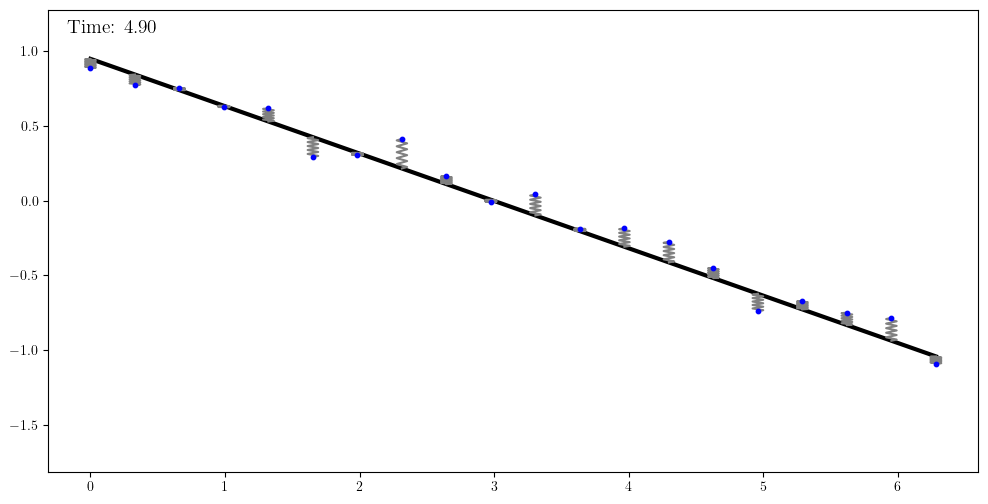

In [19]:
generalized_animation(ts, thetas[:,1,:], np.array(u_i.flatten()), np.array(y_i.flatten()), path='anis/ss1d-linear.gif', frame_skip=20)

#### Dynamics for different parameters

In [21]:
os.makedirs("data", exist_ok=True)

np.random.seed(0)
torch.manual_seed(0)
u_i = torch.linspace(0, 2*torch.pi, 20).unsqueeze(1)
y_i = torch.zeros_like(u_i)


boundaries = (torch.min(u_i, dim=0).values, torch.max(u_i, dim=0).values)

batch_size, t_size = 1, 1000
ts = torch.linspace(0, 5, t_size)

friction_values = [2, 4, 8, 16]
temp_values = [1e-4, 1e-3, 1e-2, 1e-1]

def simulate(ts, friction_values, temp_values):
    y0 = None
    results = {}
    potential_eng = {}
    for i, temp in enumerate(temp_values):
        friction_results = []
        costs_results = []
        for friction in friction_values:
            sde = GS3DE([1], boundaries, 1, friction=friction, temp=temp, k=1, M=1, kb=1)
            sde.update_data(u_i, y_i)
            y0 = 0.5*torch.rand(size=(batch_size, sde.state_size)) if y0 is None else y0

            with torch.no_grad():
                ys = torchsde.sdeint(sde, y0, ts, method="euler")
            friction_results.append((ts.cpu(), ys[:, 0, :1+1].squeeze().t().cpu()))
            costs = sde.cost(ys[:, 0, :]).detach().numpy()
            costs_results.append((ts.cpu(), costs))
        results[temp] = friction_results
        potential_eng[temp] = costs_results


    with open('data/sim_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    with open('data/pt_energy.pkl', 'wb') as f:
        pickle.dump(potential_eng, f)

In [ ]:
simulate(ts, friction_values, temp_values)

In [22]:
import matplotlib.patches as mpatches

colors = plt.cm.inferno(np.linspace(0, 1, len(friction_values)+1))

def format_scientific(value):
    if value == 0:
        return "0"
    exponent = int(f"{value:e}".split('e')[-1])
    return r"10^{{{}}}".format(exponent)

def plot_results():
    with open('data/sim_results.pkl', 'rb') as f:
        results = pickle.load(f)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()

    max_val = 0
    min_val = 0
    for i, (temp, costs_results) in enumerate(results.items()):
        for j, (ts_cpu, costs) in enumerate(costs_results):
            costs = costs[0]
            max_val = max(max_val, max(costs))
            min_val = min(min_val, min(costs))
    
    for i, (temp, friction_results) in enumerate(results.items()):
        for j, (ts_cpu, ys_cpu) in enumerate(friction_results):
            axs[i].plot(ts_cpu, ys_cpu[0], color=colors[j])

        axs[i].set_xlabel(r"$t$", fontsize=30)
        axs[i].set_ylabel(r"$x_0(t)$", fontsize=30)

        data_str = rf"$T={format_scientific(temp)}$"
        axs[i].text(0.64, 0.94, data_str, transform=axs[i].transAxes, fontsize=30, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle="round"))
        axs[i].tick_params(axis='both', which='major', labelsize=30) 
        axs[i].set_ylim(min_val*1.1, max_val*1.1)

        axs[i].axhline(0, color="black", linestyle="--", linewidth=1.5)

        if i==0 or i==1:
            axs[i].set_xticklabels([])
            axs[i].set_xlabel("")
        if i==1 or i==3:
            axs[i].set_yticklabels([])
            axs[i].set_ylabel("")

    legend_elements = [
        mpatches.Patch(color=colors[i], label=rf"$\gamma = {friction}$")
        for i, friction in enumerate(friction_values)
    ]


    fig.legend(
        handles=legend_elements, framealpha=0.8, handlelength=1.5, handleheight=1.0, fontsize=26, 
        loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.08)
    )

    plt.tight_layout()
    plt.savefig("figs/positions_params.pdf", bbox_inches="tight")
    plt.show()

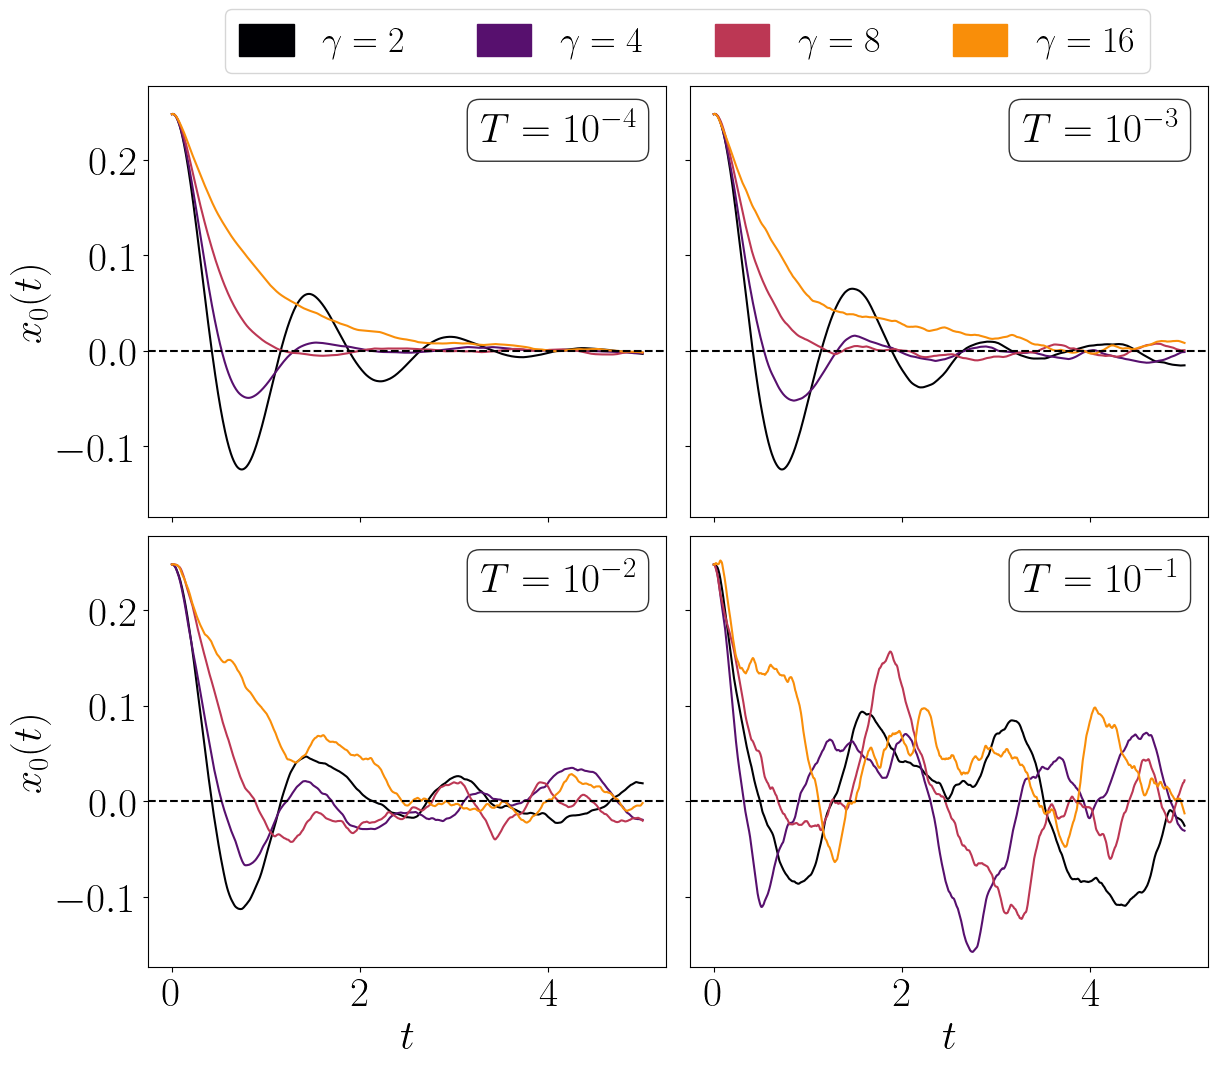

In [23]:
plot_results()

#### Dynamics in 2D functions

In [26]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# func_name = "\sin(x)+\cos(y)"
# func = lambda u: torch.sin(u[:,0]) + torch.cos(u[:,1])

func_name = "x^2 + x\cdot y^2"
func = lambda u: (u[:,0])**2 + u[:,0]*(u[:,1])**2

torch.manual_seed(42)
np.random.seed(42)

num_epochs = 1
num_runs = 1
t_size = 100
fric = 20
batch_size = 80
max_time = 5

# Generate training data: 160 points in 2 dims
N_train = 80
u_i_train = torch.rand(N_train, 2)*2*np.pi - np.pi
y_i_train = func(u_i_train) #+ eps * torch.randn(N_train)
y_i_train = y_i_train.unsqueeze(1) 

# Generate test data: 160 points in 2 dims
N_test = 80
u_i_test = torch.rand(N_test, 2)
y_i_test = func(u_i_test) #+ eps * torch.randn(N_test)
y_i_test = y_i_test.unsqueeze(1)

# Determine boundaries from combined data for SDE initialization
u_cat = torch.cat([u_i_train, u_i_test], dim=0)
u_min = torch.min(u_cat, dim=0).values
u_max = torch.max(u_cat, dim=0).values
boundaries = (u_min, u_max)

# Create DataLoaders
dataset_train = TensorDataset(u_i_train, y_i_train)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test = TensorDataset(u_i_test, y_i_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# SDE model parameters: mapping ℝ² → ℝ, so use max_features=1.
# For a 2D input, we use n_sticks of size [2,2] (hidden dimension = 4)
n_sticks = torch.tensor([4, 4])
num_labels = 1

sde = GS3DE(n_sticks, boundaries, num_labels,
                    friction=fric, temp=0.001, k=1, M=1)

# Define a simple MLP: 2 → hidden_dim → 1
input_dim = 2
hidden_dim = int(torch.prod(n_sticks).item())  # here, 2*2 = 4
mlp = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, num_labels)
)

mlp_fixed = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, num_labels)
)

with torch.no_grad():
    for layer in mlp_fixed:
        if isinstance(layer, nn.Linear) and layer.bias is not None:
            layer.bias.copy_(torch.randn_like(layer.bias))
            layer.bias.requires_grad = False

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(mlp.parameters(), lr=0.1) 
optimizerf = optim.SGD(mlp_fixed.parameters(), lr=0.1)

# Time steps for SDE integration
ts = torch.linspace(0, max_time, t_size)

# Containers for loss histories
sde_train_losses = []
mlp_train_losses = []
mlpf_train_losses = []
sde_test_losses = []
mlp_test_losses = []
mlpf_test_losses = []

theta0 = None  # initial condition for SDE integration

all_thetas = None

for epoch in range(num_epochs):
    sde_epoch_loss = 0.0
    mlp_epoch_loss = 0.0
    mlpf_epoch_loss = 0.0
    n_batch_train = len(loader_train)
    
    for u_batch, y_batch in loader_train:
        # Update SDE with current batch (note transpose: shape becomes [features, batch_size])
        sde.update_data(u_batch, y_batch)
        # sde = GS3DE(n_sticks, u_batch.t(), y_batch.t(), friction=fric, temp=0.001, k=1, M=1, boundaries=boundaries)
        theta0 = torch.rand(size=(num_runs, sde.state_size)) if theta0 is None else theta0
        loss_sde = sde.loss(theta0.flatten(), u_batch, y_batch)
        # loss_sde = sde.loss(theta0.flatten())
        sde_epoch_loss += loss_sde.item()
        with torch.no_grad():
            thetas = torchsde.sdeint(sde, theta0, ts, method='euler')
        theta0 = thetas[-1, :]

        all_thetas = thetas if all_thetas is None else torch.cat([all_thetas, thetas], dim=0)
        
        optimizer.zero_grad()
        optimizerf.zero_grad()
        mlp_out = mlp(u_batch)
        mlpf_out = mlp_fixed(u_batch)
        
        loss_mlp = criterion(mlp_out, y_batch)
        loss_mlp.backward()
        optimizer.step()

        loss_mlpf = criterion(mlpf_out, y_batch)
        loss_mlpf.backward()
        optimizerf.step()

        mlp_epoch_loss += loss_mlp.item()
        mlpf_epoch_loss += loss_mlpf.item()
    
    sde_epoch_loss /= n_batch_train
    mlp_epoch_loss /= n_batch_train
    mlpf_epoch_loss /= n_batch_train
    sde_train_losses.append(sde_epoch_loss)
    mlp_train_losses.append(mlp_epoch_loss)
    mlpf_train_losses.append(mlpf_epoch_loss)
    
    # Evaluation on test data
    sde_test_loss = 0.0
    mlp_test_loss = 0.0
    mlpf_test_loss = 0.0
    n_batch_test = len(loader_test)
    with torch.no_grad():
        for u_batch, y_batch in loader_test:
            sde_test_loss += sde.loss(theta0.flatten(), u_batch, y_batch).item()
            mlp_out = mlp(u_batch)
            mlp_test_loss += criterion(mlp_out, y_batch).item()
            mlpf_out = mlp_fixed(u_batch)
            mlpf_test_loss += criterion(mlpf_out, y_batch).item()
    sde_test_loss /= n_batch_test
    mlp_test_loss /= n_batch_test
    mlpf_test_loss /= n_batch_test
    sde_test_losses.append(sde_test_loss)
    mlp_test_losses.append(mlp_test_loss)
    mlpf_test_losses.append(mlpf_test_loss)
    
    print(f"Function: {func_name}, Epoch {epoch+1}/{num_epochs} -- "
            f"SDE Train: {sde_epoch_loss:.4f}, MLP Train: {mlp_epoch_loss:.4f}, "
            f"SDE Test: {sde_test_loss:.4f}, MLP Test: {mlp_test_loss:.4f}, "
            f"MLPf Train: {mlpf_epoch_loss:.4f}, MLPf Test: {mlpf_test_loss:.4f}"
            )
            

IndexError: too many indices for tensor of dimension 1

#### Thermodynamic learning barrier

In [141]:
from src.entropy import get_entropy_rates, get_free_energy

torch.manual_seed(0)
u_i = torch.linspace(0, 2*torch.pi, 20).unsqueeze(1)
y_i = 0.1*torch.randn_like(u_i) + 1 + (-1/3)*u_i

boundaries = (torch.min(u_i, dim=0).values, torch.max(u_i, dim=0).values)
n_labels = y_i.shape[1]
ns = 1 
batch_size, t_size = 1000, 1000
ts = torch.linspace(0, 5, t_size)

def run_simulation(k, M, fric, T):
    sde = GS3DE(ns,boundaries, n_labels, friction=fric, temp=T, k=k, M=M)

    theta0 = (torch.rand(size=(batch_size, sde.state_size)))
    with torch.no_grad():
        sde.update_data(u_i, y_i)
        thetas = torchsde.sdeint(sde, theta0, ts, method='euler')  # (t_size, batch_size, state_size) 
    
    losses = torch.stack([sde.loss(thetas[:, I, :], u_i, y_i) for I in range(batch_size)], dim=1)
    losses_mean = losses.mean(axis=1)
    losses_std = losses.std(axis=1)
    pit, phit, dSdt = get_entropy_rates(thetas, sde)
    dF = get_free_energy(ts, thetas, sde)
    
    return ts, pit, phit, dSdt, dF, losses_mean, losses_std, losses, thetas

In [162]:
k_values = np.logspace(-30, -15, num=15)
M_values = k_values
fric = [1]
temp_values = np.logspace(-1, 2, num=5)
results = {}

In [163]:
for k, M in zip(k_values, M_values):
    print("Running simulation for k =", k, ", M =", M)
    for T in temp_values:
        ts, pit, phit, dSdt, dF, losses_mean, losses_std, losses, thetas = run_simulation(k, M, fric[0], T)
        results[(k, M, fric[0], T)] = (ts, pit, phit, dSdt, dF, losses_mean, losses_std, losses, thetas)

import pickle
with open('data/fe_results_thetas.pkl', 'wb') as f:
    pickle.dump(results, f)

Running simulation for k = 1e-30 , M = 1e-30


/Users/luismantilla/Desktop/UofT/2024-2/Projects/SpringsSticks/springs-and-sticks/src/entropy.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diag = torch.tensor(diag)


Running simulation for k = 1.1787686347935914e-29 , M = 1.1787686347935914e-29
Running simulation for k = 1.389495494373136e-28 , M = 1.389495494373136e-28
Running simulation for k = 1.637893706954068e-27 , M = 1.637893706954068e-27
Running simulation for k = 1.9306977288832457e-26 , M = 1.9306977288832457e-26
Running simulation for k = 2.275845926074791e-25 , M = 2.275845926074791e-25
Running simulation for k = 2.6826957952797384e-24 , M = 2.6826957952797384e-24
Running simulation for k = 3.1622776601683793e-23 , M = 3.1622776601683793e-23
Running simulation for k = 3.727593720314923e-22 , M = 3.727593720314923e-22
Running simulation for k = 4.3939705607607864e-21 , M = 4.3939705607607864e-21
Running simulation for k = 5.1794746792312235e-20 , M = 5.1794746792312235e-20
Running simulation for k = 6.105402296585314e-19 , M = 6.105402296585314e-19
Running simulation for k = 7.19685673001153e-18 , M = 7.19685673001153e-18
Running simulation for k = 8.48342898244076e-17 , M = 8.4834289824

In [170]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma

def kl_knn(X, Y, k=10, jitter=1e-10):
    """
    Improved kNN KL(p||q) estimator (Kozachenko–Leonenko / Wang et al.)
    X ~ p, Y ~ q
    X, Y: (N, d) arrays
    """

    # --- pooled z-score (fix metric) ---
    Z = np.vstack([X, Y])
    mean = Z.mean(axis=0)
    std = Z.std(axis=0) + 1e-12
    X = (X - mean) / std
    Y = (Y - mean) / std

    # --- jitter to avoid zero distances ---
    rng = np.random.default_rng(0)
    X = X + jitter * rng.normal(size=X.shape)
    Y = Y + jitter * rng.normal(size=Y.shape)

    N, d = X.shape
    M = Y.shape[0]

    # kNN distances in X
    nn_X = NearestNeighbors(n_neighbors=k+1).fit(X)
    rho = nn_X.kneighbors(X, return_distance=True)[0][:, -1]

    # kNN distances in Y
    nn_Y = NearestNeighbors(n_neighbors=k).fit(Y)
    nu = nn_Y.kneighbors(X, return_distance=True)[0][:, -1]

    return (
        digamma(M)
        - digamma(N)
        + d * np.mean(np.log(nu / rho))
    )

with open('data/fe_results_thetas.pkl', 'rb') as f:
    results = pickle.load(f)

ks = {T: [] for T in temp_values if T > 0}
dFs = {T: [] for T in temp_values if T > 0}
final_losses = {T: [] for T in temp_values if T > 0}
kl_divs = {T: [] for T in temp_values if T > 0}


for (k, M, fric, T), (ts, pit, phit, dSdt, dF, losses_mean, losses_std, losses, thetas) in results.items():
    if T > 0:
        ks[T].append(k)
        dFs[T].append(-dF.item())
        final_losses[T].append(losses_mean[-1].item())

        final_dist = thetas[-1, :, :]
        initial_dist = thetas[0, :, :] 

        kl_div_value = sde.kb * T * kl_knn(initial_dist, final_dist)

        kl_divs[T].append(kl_div_value)



In [171]:
kl_divs[0.1]

[3.95973625556508e-23,
 3.1946942758666065e-23,
 2.617561996337983e-23,
 1.8730786701983147e-23,
 1.3224616541828537e-23,
 9.639807866315649e-24,
 9.032024516049963e-24,
 8.706932675761324e-24,
 8.97206485390613e-24,
 9.147842213483683e-24,
 9.292654004402767e-24,
 9.232246349826868e-24,
 9.14943317551431e-24,
 9.203315478800272e-24,
 9.23454148054522e-24]

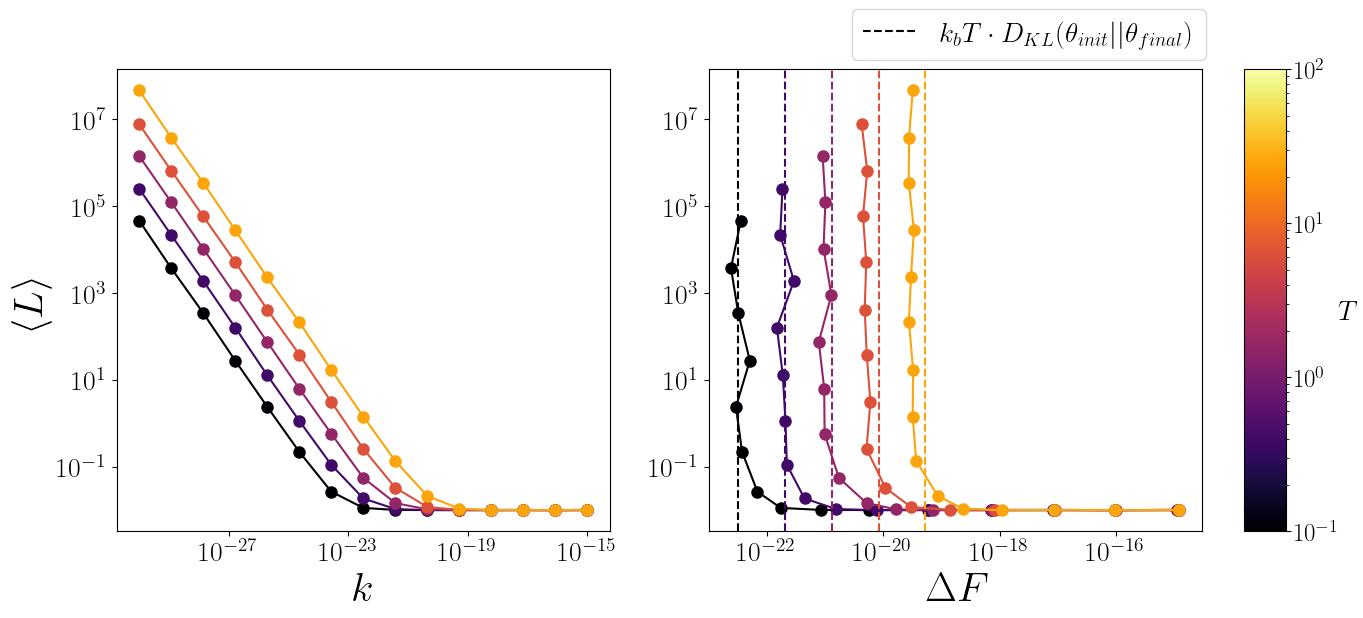

In [198]:
import matplotlib
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1, 2, figsize=(14, 6))  
axs = axs.flatten()

# put a continuous colorbar on the side for the temperature values in inferno colormap
cmap = plt.cm.inferno
colors = [cmap(i/len(temp_values)) for i in range(len(temp_values))]

for i, T in enumerate(temp_values):
    if T == 0:
        continue
    axs[0].plot(ks[T], final_losses[T], marker='o', linestyle='-', label=rf"$T={format_scientific(T)}$", color=colors[i], ms=8) 
    axs[1].plot(dFs[T], final_losses[T], marker='o', linestyle='-', label=rf"$T={format_scientific(T)}$", color=colors[i], ms=8)

    klavg = np.mean(kl_divs[T][:3])
    axs[1].axvline(klavg, color=colors[i], linestyle='--', label=rf"$D_{{KL}}$ at $T={format_scientific(T)}$")


kl_handle = Line2D(
    [0], [0],
    color='black',
    linestyle='--',
    label=r"$k_b T \cdot D_{KL}(\theta_{init}||\theta_{final})$",
)

# axs[1].legend(handles=[kl_handle], fontsize=20, loc='upper right')
axs[1].legend(
    handles=[kl_handle],
    fontsize=20,
    loc='upper left',
    bbox_to_anchor=(0.29, 1.13),
    borderaxespad=0.0
)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)

axs[0].set_xlabel(r"$k$", fontsize=30)
axs[0].set_ylabel(r"$\langle L \rangle$", fontsize=30)

axs[1].set_xlabel(r"$\Delta F$", fontsize=30)

cbar_ax = fig.add_axes([0.93, 0.11, 0.03, 0.77])
norm = matplotlib.colors.LogNorm(vmin=temp_values.min(), vmax=temp_values.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', pad=2, fraction=0.2)
cbar.set_label(f"$T$", fontsize=20, rotation=0)
cbar.ax.tick_params(labelsize=18)

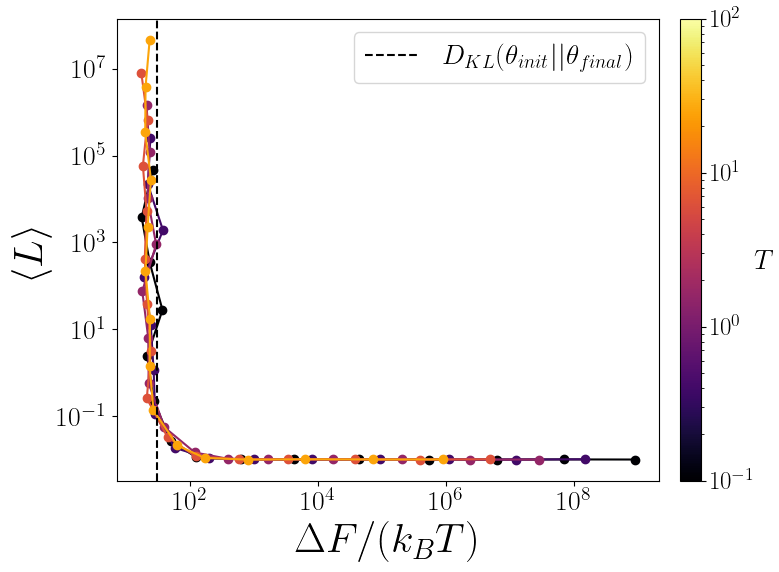

In [188]:
fig, ax = plt.subplots(figsize=(7, 6))
for i, T in enumerate(temp_values):
    if T == 0:
        continue
    ax.plot(dFs[T]/(sde.kb * T), final_losses[T], marker='o', linestyle='-', label=rf"$T={format_scientific(T)}$", color=colors[i])


meankl_overTandk = np.mean([np.mean(kl_divs[T][:3])/(sde.kb * T) for T in temp_values if T > 0])
ax.axvline(meankl_overTandk, color='black', linestyle='--', label=r"$\langle D_{KL} / (k_B T) \rangle$")

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r"$\Delta F / (k_B T)$", fontsize=30)
ax.set_ylabel(r"$\langle L \rangle$", fontsize=30)

kl_handle = Line2D(
    [0], [0],
    color='black',
    linestyle='--',
    label=r"$D_{KL}(\theta_{init}||\theta_{final})$",
)

ax.legend(handles=[kl_handle], fontsize=20, loc='upper right')



ax.tick_params(axis='both', which='major', labelsize=20)

cbar_ax = fig.add_axes([0.93, 0.11, 0.03, 0.77])
norm = matplotlib.colors.LogNorm(vmin=temp_values.min(), vmax=temp_values.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', pad=2, fraction=0.2)
cbar.set_label(f"$T$", fontsize=20, rotation=0)
cbar.ax.tick_params(labelsize=18)